## Assumptions:

Aroon is a quite popular among technical analysts, it is supposed to detect trend reversals changes in asset prices.
I think that Aroon is too granular, espcially for low to mid float stocks with low market depth.
Detecting the convexity of the curved formed by successive prices (the line generated would be a polynomial fit) of low float stocks over an extended time period should give a better signal than Aroon.

In [3]:
import pandas as pd

import yfinance as yf
from talib import MA_Type
import talib
import numpy as np
from datetime import datetime, timedelta 
from time import gmtime, strftime
from csv import writer
import os
import sqlite3

from utils.db_manage import DBManager, QuRetType, dfToRDS, std_db_acc_obj
db_acc_obj = std_db_acc_obj() 


In [4]:
"""
qu = f"SELECT * FROM NASDAQ_15 WHERE DATE > '2020-7-01'"
initialDF = db_acc_obj.exc_query(db_name='marketdata', query=qu, \
retres=QuRetType.ALLASPD)
initialDF.to_csv('nasdaq_marketdata.csv')
"""

'\nqu = f"SELECT * FROM NASDAQ_15 WHERE DATE > \'2020-7-01\'"\ninitialDF = db_acc_obj.exc_query(db_name=\'marketdata\', query=qu, retres=QuRetType.ALLASPD)\ninitialDF.to_csv(\'nasdaq_marketdata.csv\')\n'

In [31]:
dfTick = pd.read_csv('nasdaq_marketdata.csv')
dfTick = dfTick.loc[dfTick['Symbol']=='IDXG']
dfTick.to_csv('IDXG.csv')

#  : Convex

In [6]:
dfTick

,Unnamed: 0,Symbol,Date,Open,High,Low,Close,Volume
1587,1587,IDXG,2020-07-02,5.10,6.640,4.7701,6.14,5352400
5038,5038,IDXG,2020-07-03,6.14,6.140,6.1400,6.14,0
8491,8491,IDXG,2020-07-06,6.38,6.800,5.6200,6.36,1220200
11945,11945,IDXG,2020-07-07,5.83,6.340,5.4500,5.53,419200
15403,15403,IDXG,2020-07-08,5.43,5.703,5.1100,5.19,259600
...,...,...,...,...,...,...,...,...
558385,558385,IDXG,2021-02-08,4.95,5.470,4.9300,5.29,264100
562432,562432,IDXG,2021-02-09,5.30,5.790,5.1900,5.70,295200
566493,566493,IDXG,2021-02-10,5.86,5.900,5.2900,5.44,165100
570556,570556,IDXG,2021-02-11,5.43,5.990,5.3900,5.61,226800


[6.14, 6.14, 6.36, 5.53, 5.19, 5.21, 5.17, 4.67, 4.71, 5.02, 4.94, 5.51, 5.86, 6.45, 6.26, 5.96, 6.23, 5.53, 5.87, 5.72, 5.83, 5.87, 6.13, 6.4, 6.31, 6.6, 6.36, 7.06, 6.32, 6.17, 6.04, 5.78, 3.88, 3.38, 3.34, 3.36, 3.34, 3.32, 3.45, 3.35, 3.47, 3.59, 3.5, 3.24, 3.07, 2.93, 2.84, 2.89, 3.02, 3.09, 3.2, 3.27, 3.37, 3.27, 3.32, 3.39, 3.38, 3.23, 3.16, 3.0, 3.08, 3.15, 3.32, 3.09, 3.06, 3.05, 3.0, 2.92, 3.02, 3.02, 3.04, 3.0, 2.98, 3.96, 4.34, 4.01, 3.99, 3.35, 3.43, 3.705, 4.08, 3.69, 3.68, 3.39, 3.45, 3.49, 3.05, 3.06, 2.97, 2.95, 3.09, 3.18, 3.17, 3.03, 3.05, 3.1, 3.15, 3.19, 2.88, 2.89, 3.05, 3.02, 3.03, 3.19, 3.19, 3.3139999999999996, 3.17, 3.2, 3.17, 3.16, 3.18, 3.16, 3.16, 3.48, 3.45, 3.4, 3.22, 3.3, 3.3, 3.41, 3.43, 3.49, 3.41, 3.58, 3.5, 3.405, 3.21, 3.28, 3.14, 3.31, 3.48, 3.7, 4.2, 3.88, 3.88, 3.88, 3.94, 4.03, 4.1, 4.58, 4.35, 4.19, 4.03, 4.3, 4.43, 4.17, 4.24, 4.02, 4.34, 4.22, 5.05, 5.06, 4.85, 5.29, 5.7, 5.44, 5.61, 5.77]
4.006860759493671
[  0.   1.   2.   3.   4.   5.   6.

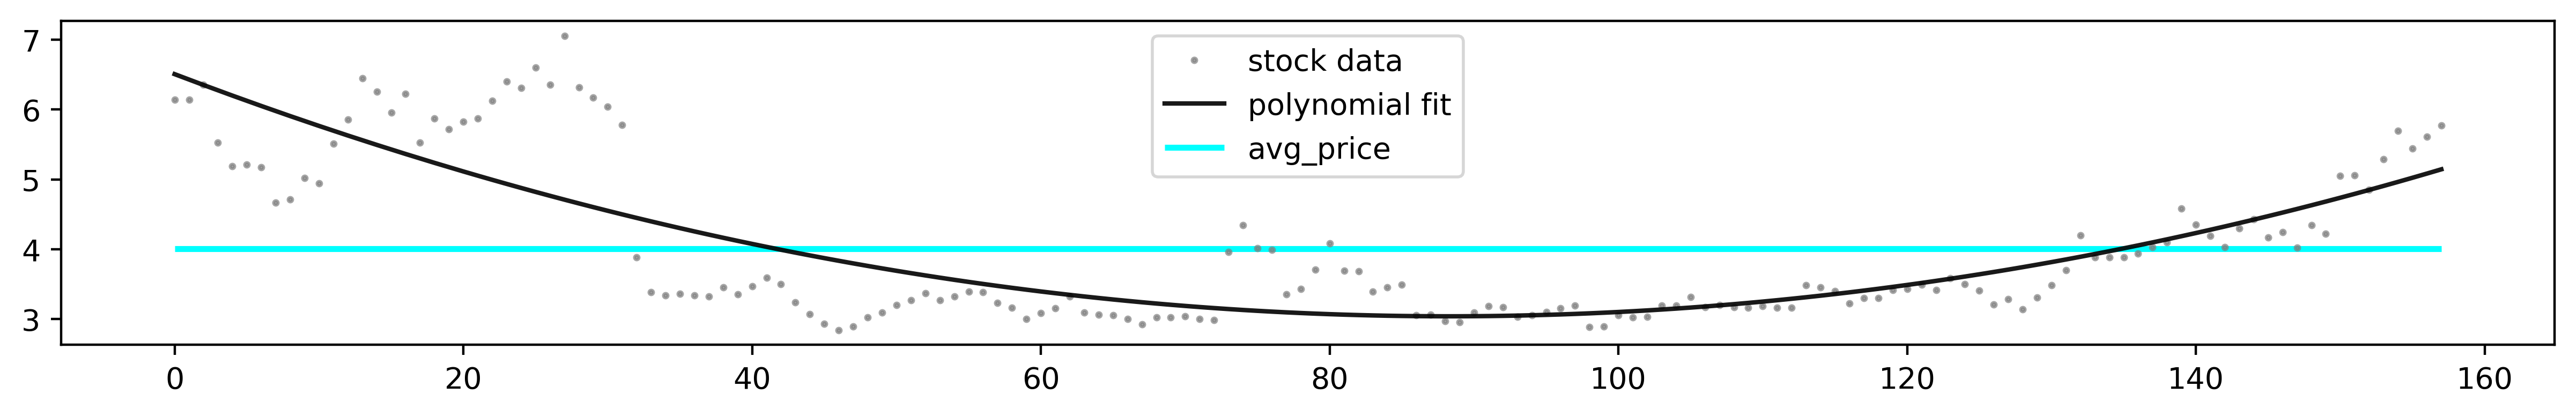

In [7]:
import matplotlib.pyplot as plt
from sympy import Symbol,expand

y_data = dfTick.Close.tolist()
x_data = range(len(y_data))
print(y_data)


avg_price = np.average(y_data)
print(avg_price)

x = np.linspace(0, max(x_data), max(x_data) + 1)
print(x)
# polynomial fit of degree xx
pol = np.polyfit(x_data, y_data, 2)
y_pol = np.polyval(pol, x)


# Printing out the equation
y1=np.poly1d(pol)
test=Symbol('x')
print("Equation: ", expand(y1(test)))


plt.figure(figsize=(15, 2), dpi= 400, facecolor='w', edgecolor='k')
plt.plot(x_data, y_data, 'o', markersize=1.5, color='grey', alpha=0.7)
plt.plot(x, y_pol, '-', markersize=1.0, color='black', alpha=0.9)
plt.hlines(y=avg_price, xmin=0, xmax=max(x_data), colors='aqua', linestyles='-', lw=2, label='Single Short Line')
plt.legend(['stock data', 'polynomial fit', 'avg_price'])
plt.show()


# To do: assess the level of conexity on degree 2 or 3
# Set a threshold of convexity
# Assumption, the first point needs to be higher than the last one or start above the average price500000

In [ ]:
Testing th

In [8]:
x= 80
fx = 0.000445761719799052*x**2 - 0.0786768388405201*x + 6.50880163303081

In [9]:
fx

3.0675295325031344

<h5> The intuitive & the programmers method </h5>




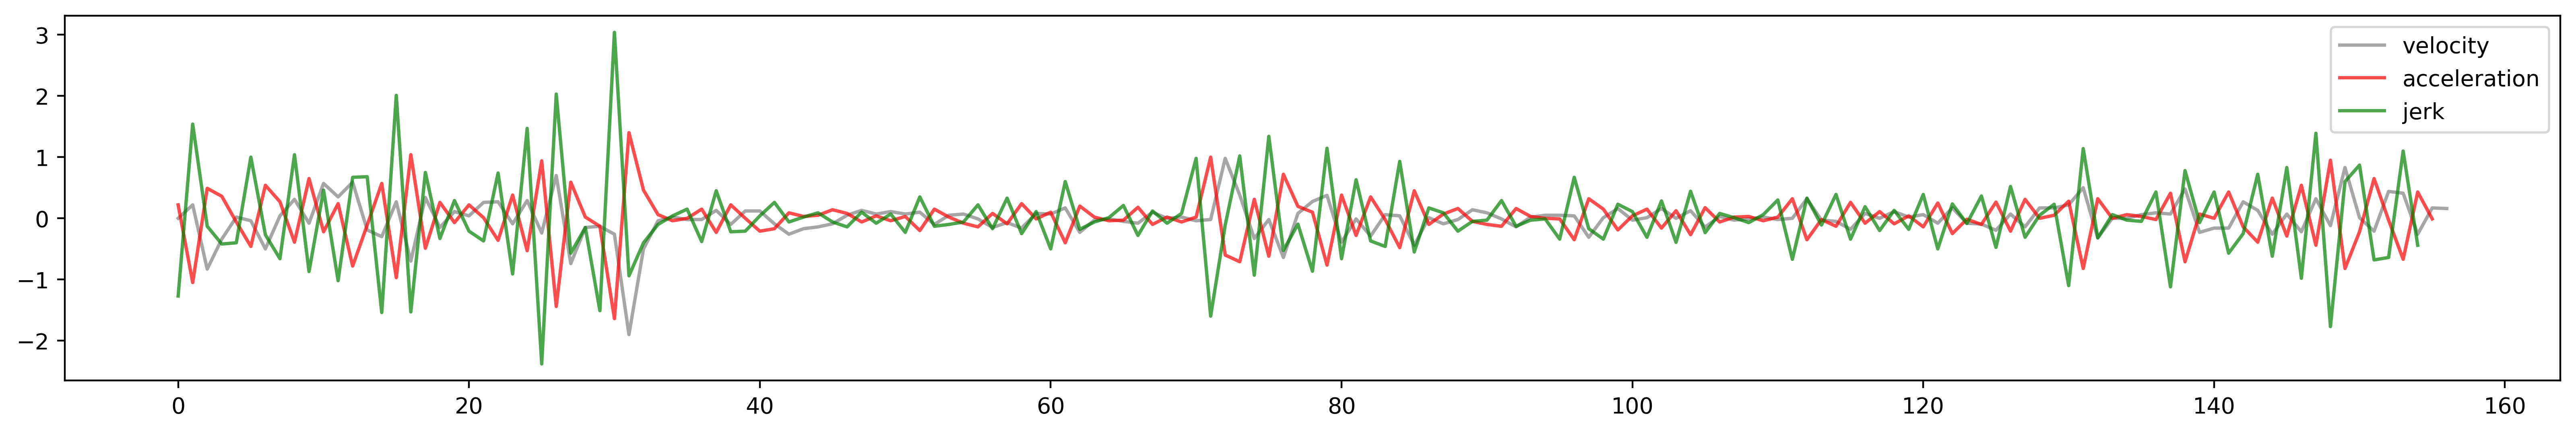

In [21]:
import numpy as np


velocity = np.diff(y_data)
acceleration = np.diff(velocity)
jerk = np.diff(acceleration)
jounce = np.diff(jerk)


plt.figure(figsize=(20, 3), dpi= 400, facecolor='w', edgecolor='k')
plt.plot(list(range(len(velocity))), velocity, '-', markersize=1.5, color='grey', alpha=0.7)
plt.plot(list(range(len(acceleration))), acceleration, '-', markersize=1.5, color='red', alpha=0.7)
plt.plot(list(range(len(jerk))), jerk, '-', markersize=1.5, color='green', alpha=0.7)

plt.legend(['velocity', 'acceleration', 'jerk'])


In [29]:
# positive numbers = rising
print("velocitiy: ", np.mean(velocity))

# positive numbers = concave up
print("acceleration: ", np.mean(acceleration))

# positive numbers = curling up
print("jerk: ", np.mean(jerk))

# positive numbers = snapping up
print("jounce: ", np.mean(jounce))


velocitiy:  -0.0023566878980891726
acceleration:  0.0010256410256410209
jerk:  -0.001483870967741944
jounce:  0.005389610389610399


Now, let's take a concave curve to prove and illlustrate this:

<h5> The mathematicians method (second derivative to check for covexity) </h5>